In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Iteration 1, RMSE: 0.04014447560656885
Iteration 2, RMSE: 0.023724884058860838
Iteration 3, RMSE: 0.01608725172520876
Iteration 4, RMSE: 0.010406247263069584
Iteration 5, RMSE: 0.007497494193078457
Iteration 6, RMSE: 0.006038908623271925
Iteration 7, RMSE: 0.005029111743708075
Iteration 8, RMSE: 0.004634609224142182
Iteration 9, RMSE: 0.004358955313994837
Iteration 10, RMSE: 0.004112655764166022
Iteration 11, RMSE: 0.003806258079474517
Iteration 12, RMSE: 0.0035074003665450594
Iteration 13, RMSE: 0.0032926323491202017
Iteration 14, RMSE: 0.0031113728911774927
Iteration 15, RMSE: 0.002803582095697645
Iteration 16, RMSE: 0.0025882442618383045
Iteration 17, RMSE: 0.0024622334528166673
Iteration 18, RMSE: 0.002366838297042055
Iteration 19, RMSE: 0.002237473486680702
Iteration 20, RMSE: 0.002045519629696095
Iteration 21, RMSE: 0.0019192229079602282
Iteration 22, RMSE: 0.0018335869618810842
Iteration 23, RMSE: 0.0017573639200679106
Iteration 24, RMSE: 0.0017110137792937868
Iteration 25, RMSE

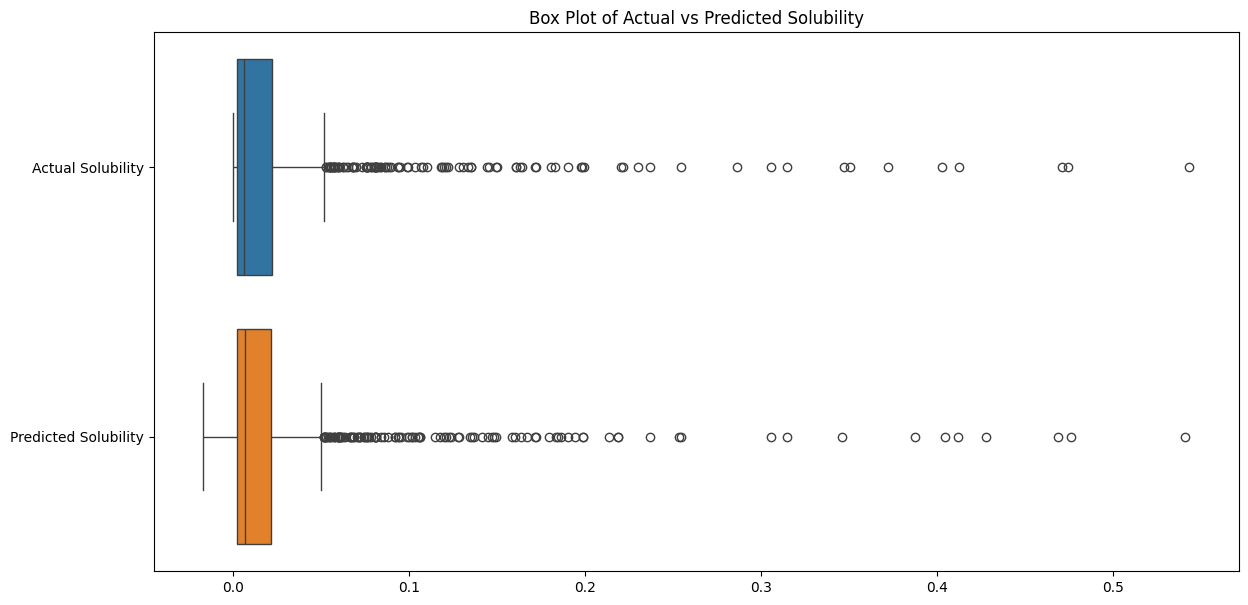

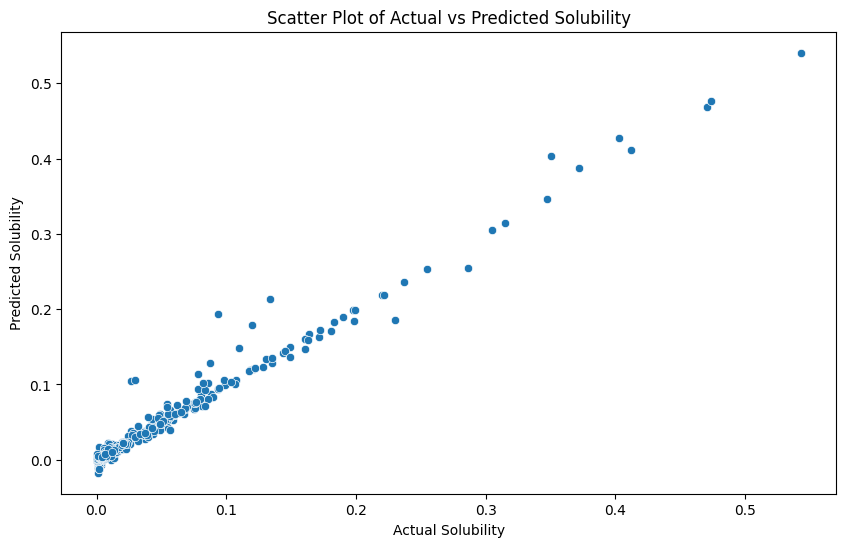

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Function to initialize models
def initialize_models(X, N):
    models = []
    for _ in range(N):
        model = LinearRegression(fit_intercept=False)  # No-intercept model
        model.fit(X, np.random.rand(X.shape[0]))
        models.append(model)
    return models

# Function to calculate prediction error
def calculate_prediction_error(models, X, y):
    errors = np.zeros((len(y), len(models)))
    for i, model in enumerate(models):
        y_pred = model.predict(X)
        errors[:, i] = (y - y_pred) ** 2
    return errors

# Function to compute membership
def compute_membership(errors):
    inv_errors = 1 / (errors + 1e-10)
    membership = inv_errors / inv_errors.sum(axis=1, keepdims=True)
    return membership

# Function to update model parameters
def update_model_parameters(models, X, y, membership):
    for i, model in enumerate(models):
        weights = membership[:, i]
        model.fit(X, y, sample_weight=weights)
    return models

# Fuzzy clustering algorithm
def fuzzy_clustering(X, y, N, max_iter=500, tol=1e-4):
    models = initialize_models(X, N)
    prev_rmse = float('inf')
    rmse_list = []

    for iteration in range(max_iter):
        errors = calculate_prediction_error(models, X, y)
        membership = compute_membership(errors)
        models = update_model_parameters(models, X, y, membership)

        avg_rmse = np.sqrt(np.mean(errors.min(axis=1)))
        rmse_list.append(avg_rmse)
        print(f'Iteration {iteration + 1}, RMSE: {avg_rmse}')

        if avg_rmse < tol:
            break
        prev_rmse = avg_rmse

    return models, membership, rmse_list

# Function to predict solubility using the best model
def predict_solubility(test_sample, X_train, y_train, models, scaler, K=3):
    test_sample_scaled = scaler.transform([test_sample])
    distances = cdist(test_sample_scaled, X_train)[0]
    nearest_indices = np.argsort(distances)[:K]

    prediction_errors = np.zeros(len(models))
    for i, model in enumerate(models):
        errors = np.abs(y_train[nearest_indices] - model.predict(X_train[nearest_indices]))
        prediction_errors[i] = np.mean(errors)

    best_model_index = np.argmin(prediction_errors)
    best_model = models[best_model_index]
    predicted_solubility = best_model.predict(test_sample_scaled)

    return predicted_solubility, best_model_index

# Load your data
data = pd.read_csv('/content/drive/MyDrive/Sai_Chem_Endsem/processed_data.csv', skiprows=1, header=None)

# Preprocess the data
X = data.drop(30, axis=1).values
y = data[30].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize parameters
N = 10  # Number of clusters/models

# Apply fuzzy clustering
models, membership, rmse_list = fuzzy_clustering(X_scaled, y, N)

# Save models and scalers if needed
joblib.dump(models, 'linear_models.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Predict solubility for all samples
predicted_solubility_list = []
best_model_indices = []

for i in range(X.shape[0]):
    test_sample = X[i, :]
    predicted_solubility, best_model_index = predict_solubility(test_sample, X_scaled, y, models, scaler)
    predicted_solubility_list.append(predicted_solubility[0])
    best_model_indices.append(best_model_index)
    print(f'Sample {i+1}: Predicted Solubility: {predicted_solubility[0]}, Best Model Index: {best_model_index}')

# Output RMSE during training
#print(f'RMSE during training: {rmse_list}')
print(f"Average RMSE: {sum(rmse_list)/len(rmse_list)}")
print(f"Minimum RMSE: {min(rmse_list)}")

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame({
    'Actual Solubility': y,
    'Predicted Solubility': predicted_solubility_list,
    'Best Model Index': best_model_indices
})

# Print the results
print(results_df)

# Print the R2 value
print(f"The R2 value is: {r2_score(y, predicted_solubility_list)}")

# Print the MAE value
print(f"The MAE value is: {mean_absolute_error(y, predicted_solubility_list)}")

# Plot the correlation using box plots
plt.figure(figsize=(14, 7))

# Box plot of actual vs predicted solubility
sns.boxplot(data=[results_df['Actual Solubility'], results_df['Predicted Solubility']], orient='h')
plt.yticks([0, 1], ['Actual Solubility', 'Predicted Solubility'])
plt.title('Box Plot of Actual vs Predicted Solubility')
plt.show()

# Scatter plot for visual comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Solubility', y='Predicted Solubility', data=results_df)
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Scatter Plot of Actual vs Predicted Solubility')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
